In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from model import QNetwork

env = 'bandit'
conflict = False
n = 64
coef_l1 = 0.0

# name
name = '{}_conflict={}_n={}_l1={}'.format(env, conflict, n, coef_l1)
name_dir = './res/{}'.format(name)

model = QNetwork(hidden_dim=n)
model.load_state_dict(torch.load(name_dir + '/model.pth'))
model.eval()  # Set the model to evaluation mode


from env import BanditEnv

env = BanditEnv(conflict=conflict)

In [3]:
# Generate all possible 17-dimensional inputs
def get_all_inputs():
    """Generate all possible 9-dimensional states."""
    all_states = []
    for cue in [0, 1, 2]:  # Two possible states
        for i in range(8):  # Four possible one-hot vectors for obj1
            for j in range(8):  # Four possible one-hot vectors for obj2
                if i != j:
                    obj1 = np.eye(8)[i]  # One-hot encoding for obj1
                    obj2 = np.eye(8)[j]  # One-hot encoding for obj2
                    # cue_onehot = np.eye(3)[cue]
                    obs = np.concatenate([obj1, obj2, [cue]])  # Combine into 17-dim input
                    all_states.append(obs)
    return np.array(all_states)

inputs = get_all_inputs()
print("input:", inputs.shape)

input: (168, 17)


In [4]:
# r, y
r, y = model.forward(torch.tensor(inputs, dtype=torch.float32))

r = r.data.cpu().numpy()
y = y.data.cpu().numpy()
print("r:", r.shape, "y:", y.shape)

# actions
actions = y.argmax(-1)

# rewards
rewards = []

for i in range(len(inputs)):
    action = actions[i]
    rewards.append(env.get_reward(obj1=inputs[i][0:8], obj2=inputs[i][8:16], cue=inputs[i][-1])[action])

rewards = np.array(rewards)
print("rewards:", rewards.shape)

r: (168, 64) y: (168, 2)
rewards: (168,)


In [6]:
cnt = 0

for i in range(168):
    r_true = env.get_reward(obj1=inputs[i, 0:8], obj2=inputs[i, 8:16], cue=inputs[i, -1])
    if np.argmax(r_true) != actions[i]:
        # print(i)
        # print(inputs[i, 0])
        cnt += 1

print(cnt)

25


In [7]:
frs = []
stds = []

for reward in [1.0, 2.0, 3.0, 4.0]:
    for cue in [0.0, 1.0, 2.0]:
        idx = (rewards == reward) & (inputs[:, -1] == cue)
        fr = np.mean(r[idx], 0)
        frs.append(fr)
        std = np.std(r[idx], 0)
        stds.append(std)

frs = np.stack(frs, axis=0).reshape(4, 3, -1)  # Now shape is (reward, cue, neuron)
stds = np.stack(stds, axis=0).reshape(4, 3, -1)
print("frs:", frs.shape)

np.savez(name_dir + '/fr.npz', frs=frs, stds=stds)

frs: (4, 3, 64)


### Plot FR tuning curves

In [7]:
n = 64
name = 'bandit_conflict=False_n=64_l1=0.0'
name_dir = './res/{}'.format(name)
temp = np.load(name_dir + '/fr.npz')
frs, stds = temp['frs'], temp['stds']

In [8]:
frs.shape

(4, 3, 64)

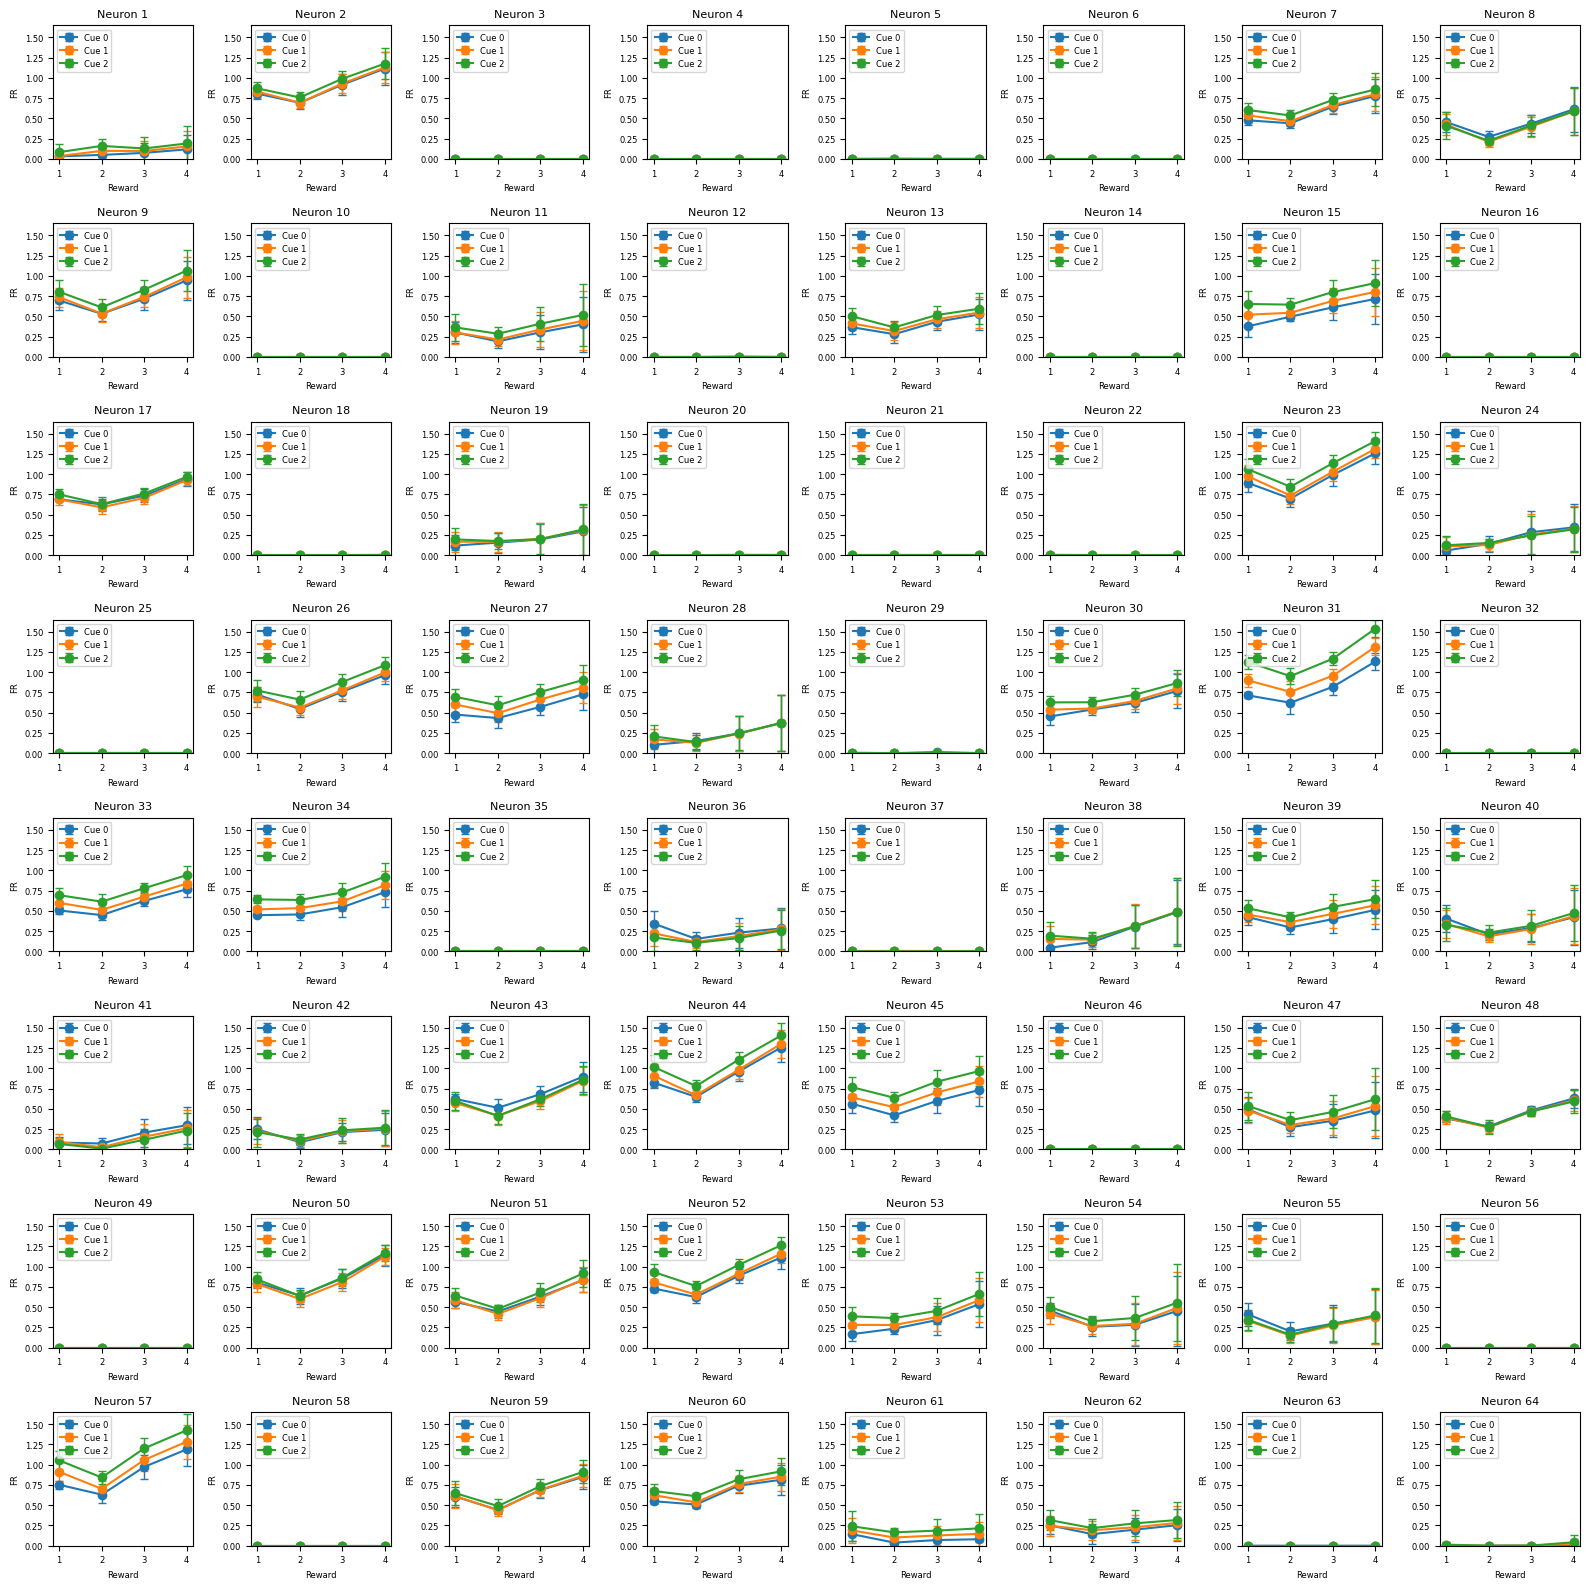

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# frs shape: (4, 3, 64) — mean firing rates
# stds shape: (4, 3, 64) — standard deviations

x_values = [1, 2, 3, 4]  # reward levels
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # default matplotlib color cycle
# colors = ['r', 'g', 'b']

fig, axes = plt.subplots(n // 8, 8, figsize=(16, n // 4))  # 64 neurons

for i, ax in enumerate(axes.flat):
    for cue in range(3):
        means = frs[:, cue, i]      # shape (4,)
        errors = stds[:, cue, i]    # shape (4,)
        color = colors[cue]

        # # Plot mean line
        # ax.plot(x_values, means, marker='o', linestyle='-', color=color, label=f'Cue {cue}')

        # # Shaded error region
        # ax.fill_between(
        #     x_values,
        #     means - errors,
        #     means + errors,
        #     color=color,
        #     alpha=0.2,
        #     linewidth=0
        # )
        
        ax.errorbar(
            x_values,
            means,
            yerr=errors,
            marker='o',
            linestyle='-',
            color=colors[cue],
            label=f'Cue {cue}',
            capsize=3,
            elinewidth=1
        )


    ax.set_title(f"Neuron {i+1}", fontsize=8)
    ax.set_xticks(x_values)
    ax.set_ylim(0, np.max(frs + stds))  # scale to full range
    ax.set_xlabel("Reward", fontsize=6)
    ax.set_ylabel("FR", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.legend(fontsize=6, loc='upper left')

plt.tight_layout()
plt.savefig('./res/fr_{}.pdf'.format(name), dpi=300, bbox_inches='tight')
# plt.show()

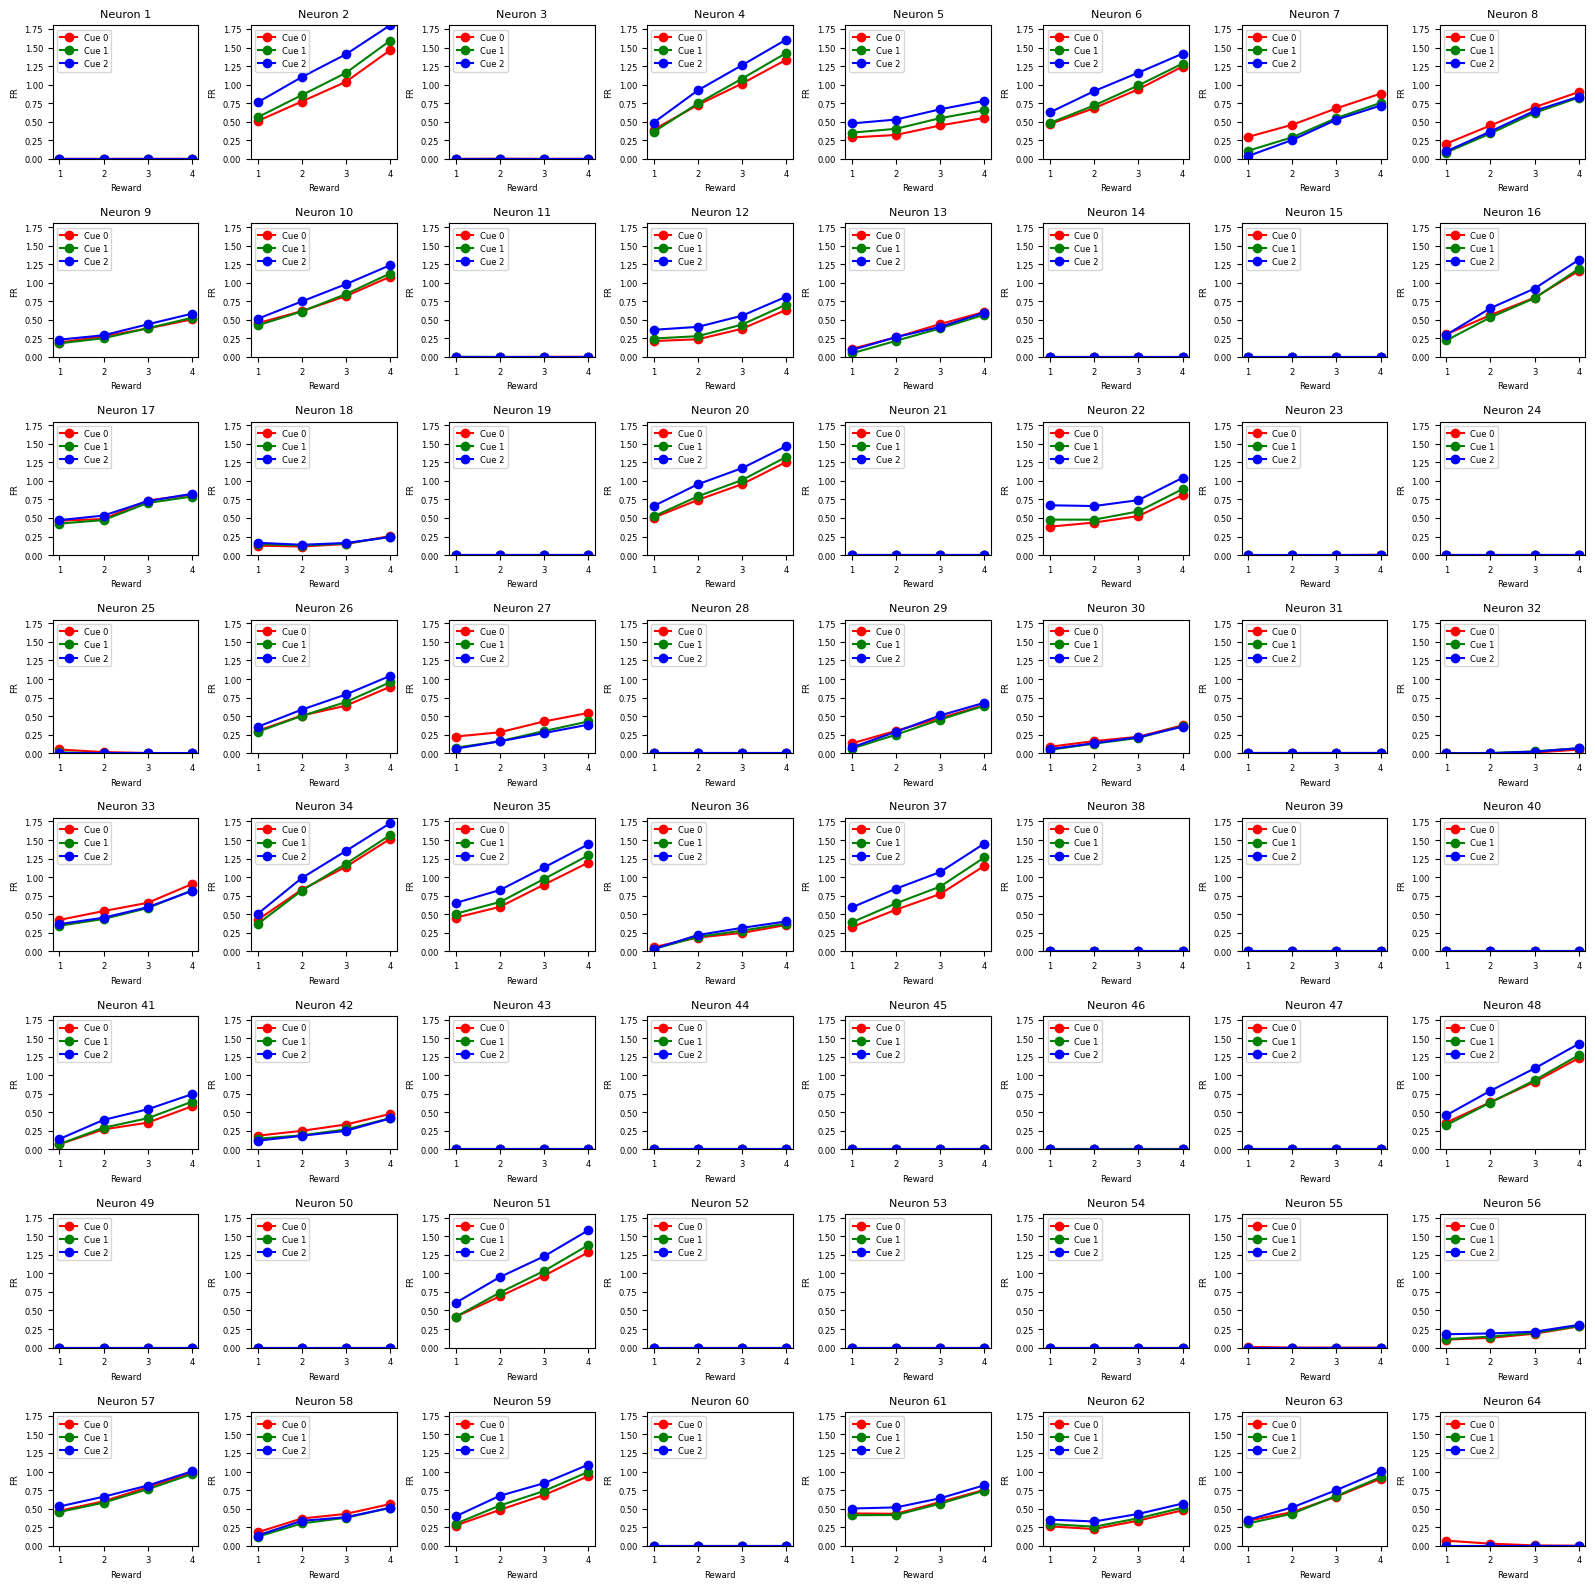

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# frs shape: (4, 3, 64) — [reward, cue, neuron]
# We want 64 plots (one per neuron), each with 3 lines (one per cue)

x_values = [1, 2, 3, 4]  # reward levels
cue_colors = ['r', 'g', 'b']  # colors for cue 0, 1, 2

fig, axes = plt.subplots(8, 8, figsize=(16, 16))  # 64 neurons in 8x8 grid

# Loop through each neuron (0 to 63)
for i, ax in enumerate(axes.flat):
    for cue in range(3):
        y_values = frs[:, cue, i]  # shape (4,) — 4 rewards for this cue
        ax.plot(x_values, y_values, marker='o', linestyle='-', color=cue_colors[cue], label=f'Cue {cue}')

    ax.set_title(f"Neuron {i+1}", fontsize=8)
    ax.set_xticks(x_values)
    ax.set_ylim(0, np.max(frs))  # normalize y-axis
    ax.set_xlabel("Reward", fontsize=6)
    ax.set_ylabel("FR", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.legend(fontsize=6, loc='upper left')

plt.tight_layout()
plt.savefig('fr_{}.pdf'.format(name), dpi=300, bbox_inches='tight')
plt.show()

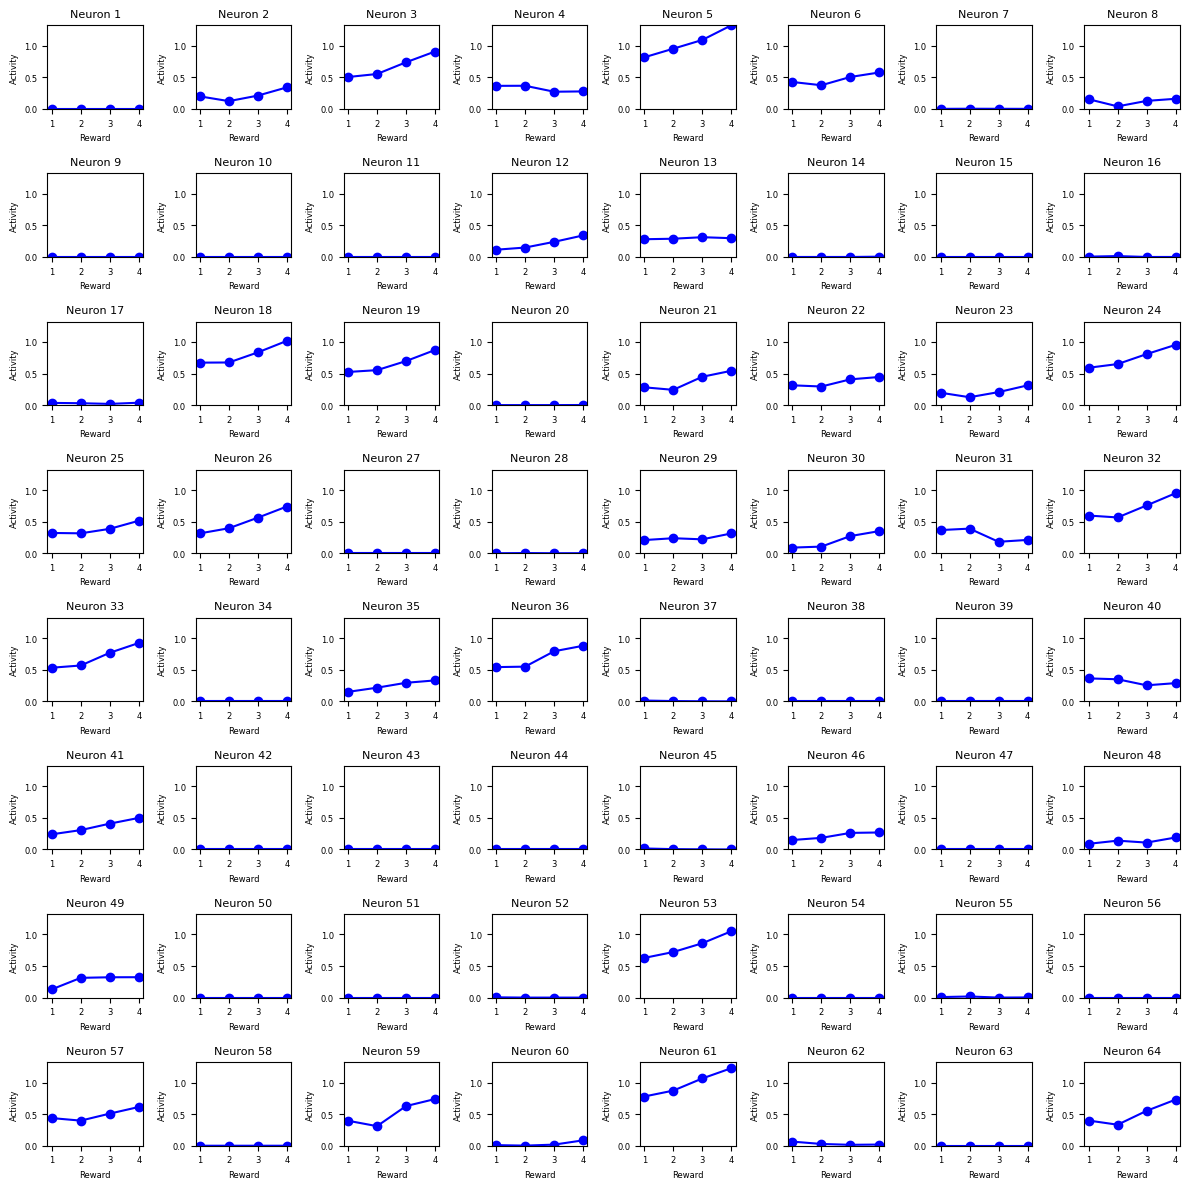

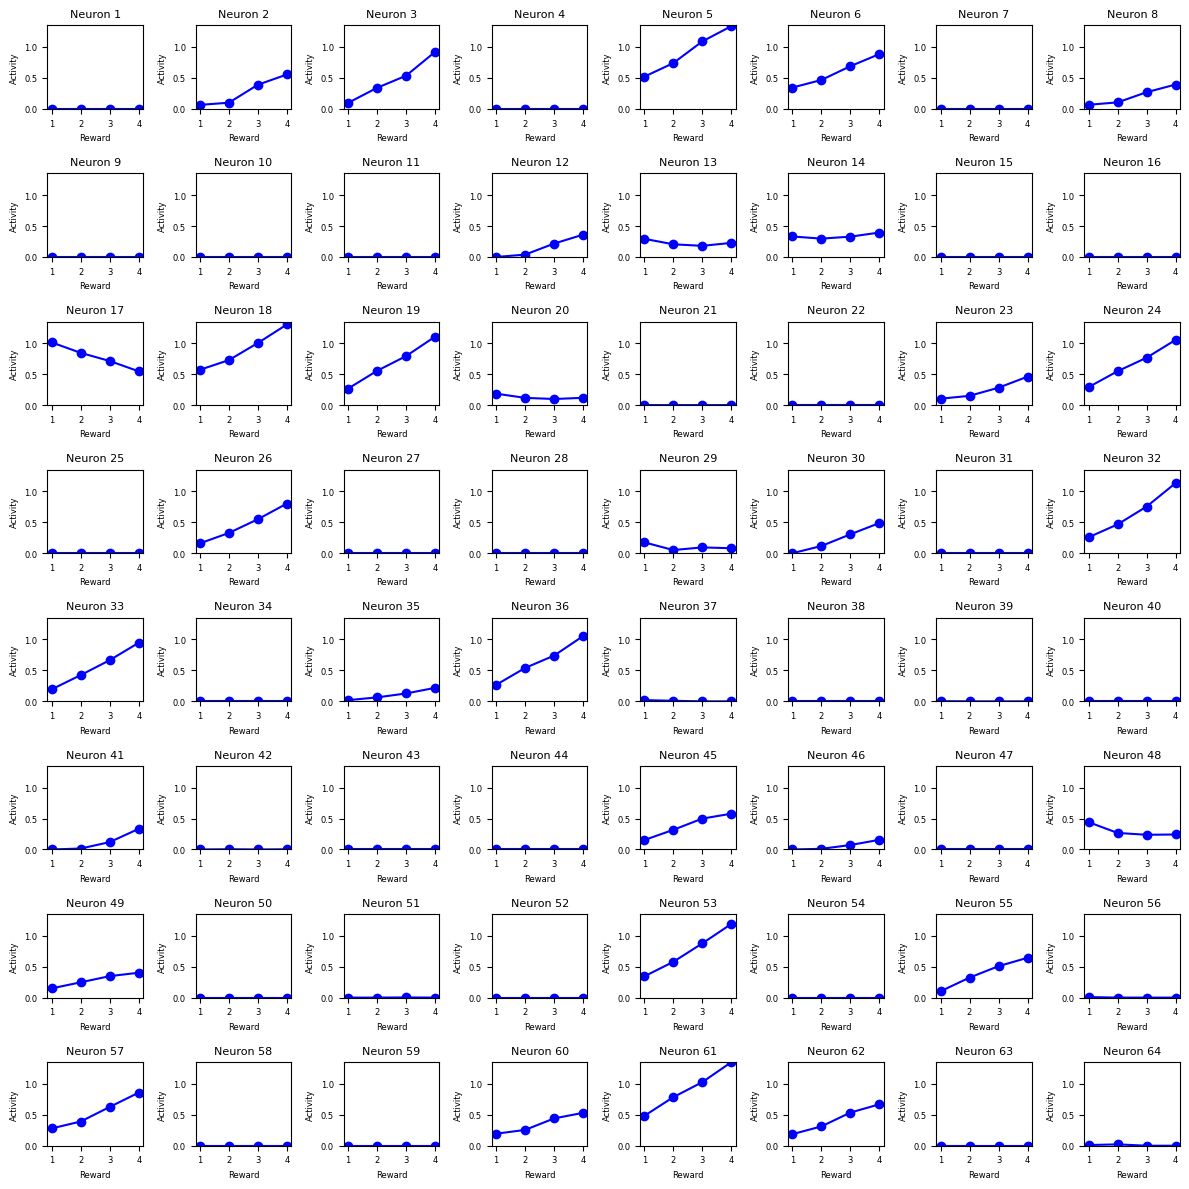

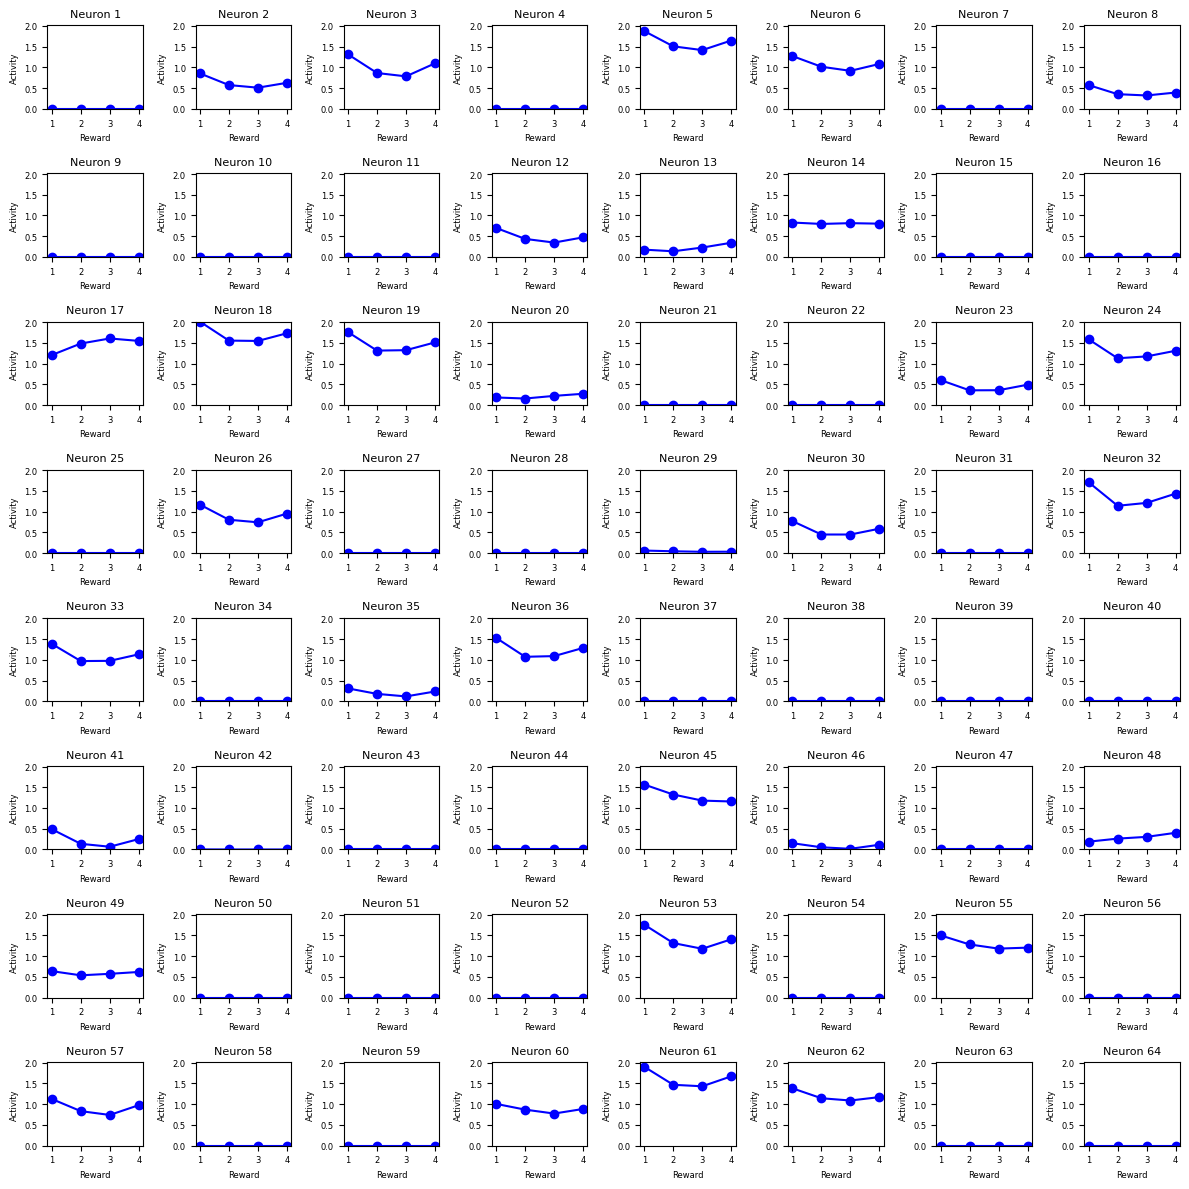

In [9]:
import matplotlib.pyplot as plt
import numpy as np


for cue in [0, 1, 2]:
    # Shape: (64, 4) -> 64 neurons, each with a 4-dimensional response
    neuron_activity = frs[:, cue, :].T

    # X-axis values corresponding to rewards (1, 2, 3, 4)
    x_values = [1, 2, 3, 4]

    # Create 64 subplots in an 8x8 grid
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))

    for i, ax in enumerate(axes.flat):
        ax.plot(x_values, neuron_activity[i], marker='o', linestyle='-', color='b')  # Line plot
        ax.set_xticks(x_values)
        ax.set_ylim(0, np.max(neuron_activity))  # Normalize y-axis
        ax.set_title(f"Neuron {i+1}", fontsize=8)
        ax.set_xlabel("Reward", fontsize=6)
        ax.set_ylabel("Activity", fontsize=6)
        ax.tick_params(axis='both', which='major', labelsize=6)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.savefig('{}_{}.pdf'.format(name, cue), dpi=300, bbox_inches='tight')

(-0.5, 63.5, 3.5, -0.5)

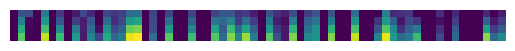

In [63]:
plt.imshow(frs)
plt.axis('off')

In [22]:
idx_state1 = inputs[:, 0] == 0

r[idx_state1, :].shape

(256, 64)

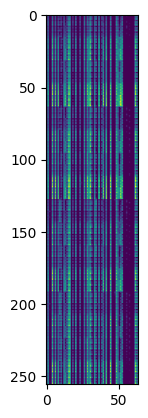

In [24]:
plt.imshow(r[idx_state1, :])